# Kalman Filter Prediction

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import os

path = './lacity/'
data = pd.read_csv(os.path.join(path, 'lacity.org-website-traffic.csv'), 
                   parse_dates=['Date']).loc[:, ['Date', 'Device Category', 'Sessions']]
data = data.groupby(['Date', 'Device Category'], as_index=False)['Sessions'].sum()

fixes = pd.DataFrame({'Date': pd.to_datetime(['2016-12-01', '2018-10-13']), 
                      'Device Category': ['tablet', 'tablet'] ,
                      'Sessions': [0, 0]})
data = pd.concat([data, fixes], axis=0, ignore_index=True)

In [2]:
data

,Date,Device Category,Sessions
0,2014-01-01,desktop,1032805
1,2014-01-01,mobile,537573
2,2014-01-01,tablet,92474
3,2014-01-02,desktop,2359710
4,2014-01-02,mobile,607544
...,...,...,...
6190,2019-08-27,desktop,438
6191,2019-08-27,mobile,557
6192,2019-08-27,tablet,80
6193,2016-12-01,tablet,0


In [3]:
train = data.loc[data['Date'] < '2019-01-01']
valid = data.loc[(data['Date'] >= '2019-01-01') & (data['Date'] < '2019-04-01')]
h = valid['Date'].nunique()
h

90

In [4]:
from darts import TimeSeries

series_names = train['Device Category'].unique()
train_series = TimeSeries.from_group_dataframe(train, time_col='Date', value_cols=['Sessions'], 
                                               group_cols=['Device Category'], freq='D', 
                                               fill_missing_dates=True, 
                                               fillna_value=0.)

In [5]:
from darts.models import KalmanForecaster

preds = list()
for i, series in enumerate(train_series):
    model = KalmanForecaster(dim_x=100)
    model.fit(series=series)
    p = model.predict(h).pd_dataframe().reset_index()
    p['Device Category'] = series_names[i]
    preds.append(p)
preds = pd.concat(preds, axis=0, ignore_index=True).rename(columns={'Sessions': 'Predicted'})

/home/dev/miniconda3/envs/kf/lib/python3.12/site-packages/statsforecast/core.py:26: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
/home/dev/miniconda3/envs/kf/lib/python3.12/site-packages/statsforecast/utils.py:237: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  "ds": pd.date_range(start="1949-01-01", periods=len(AirPassengers), freq="M"),


In [6]:
preds = preds.merge(valid, on=['Date', 'Device Category'], how='left')
    
from sklearn.metrics import mean_absolute_percentage_error
mean_absolute_percentage_error(preds['Sessions'], preds['Predicted'])

0.3147316530391112

/tmp/ipykernel_25821/2564824918.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns={'Sessions': 'Actual'}, inplace=True)
/tmp/ipykernel_25821/2564824918.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns={'Sessions': 'Actual'}, inplace=True)
/tmp/ipykernel_25821/2564824918.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns={'Sessions': 'Actual'}, inplace=True)


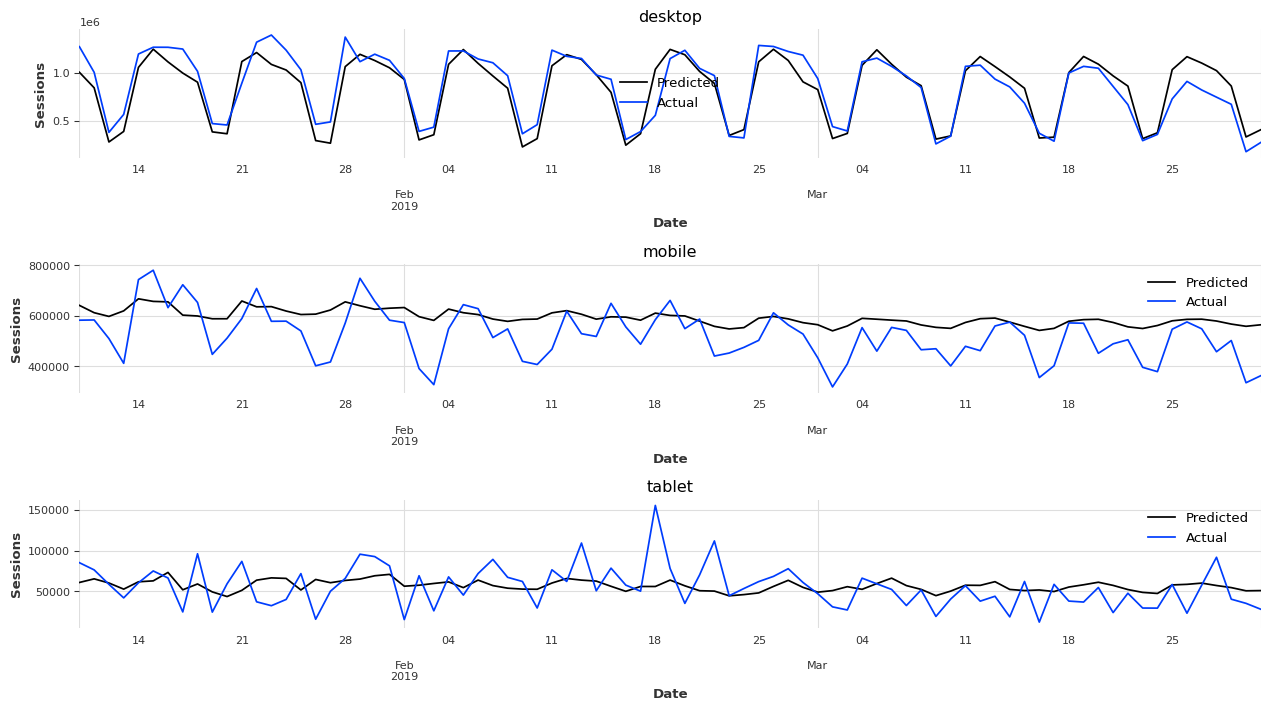

In [7]:
fig,ax = plt.subplots(3,1,figsize=(1280/96, 720/96), dpi=96)
preds_ = preds[preds['Date'] >= '2019-01-10']
for ax_, device in enumerate(preds_['Device Category'].unique()):
    p_ = preds_.loc[preds_['Device Category'] == device]
    p_.rename(columns={'Sessions': 'Actual'}, inplace=True)
    p_.plot(x='Date', y=['Predicted', 'Actual'], ax=ax[ax_], title=device)
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sessions')
fig.tight_layout()

In [8]:
from darts.models import KalmanForecaster

preds = list()
for i, series in enumerate(train_series):
    model = KalmanForecaster(dim_x=100)
    model.fit(series=series)
    p = model.predict(h, num_samples=100)
    p = [p.quantile_df(q) for q in [0.05, 0.5, 0.95]]
    p = pd.concat(p, axis=1).reset_index()
    p['Device Category'] = series_names[i]
    preds.append(p)
preds = pd.concat(preds, axis=0, ignore_index=True)
preds = preds.merge(valid, on=['Date', 'Device Category'], how='left')

/tmp/ipykernel_25821/4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
/tmp/ipykernel_25821/4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
/tmp/ipykernel_25821/4125556309.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  p_.rename(columns

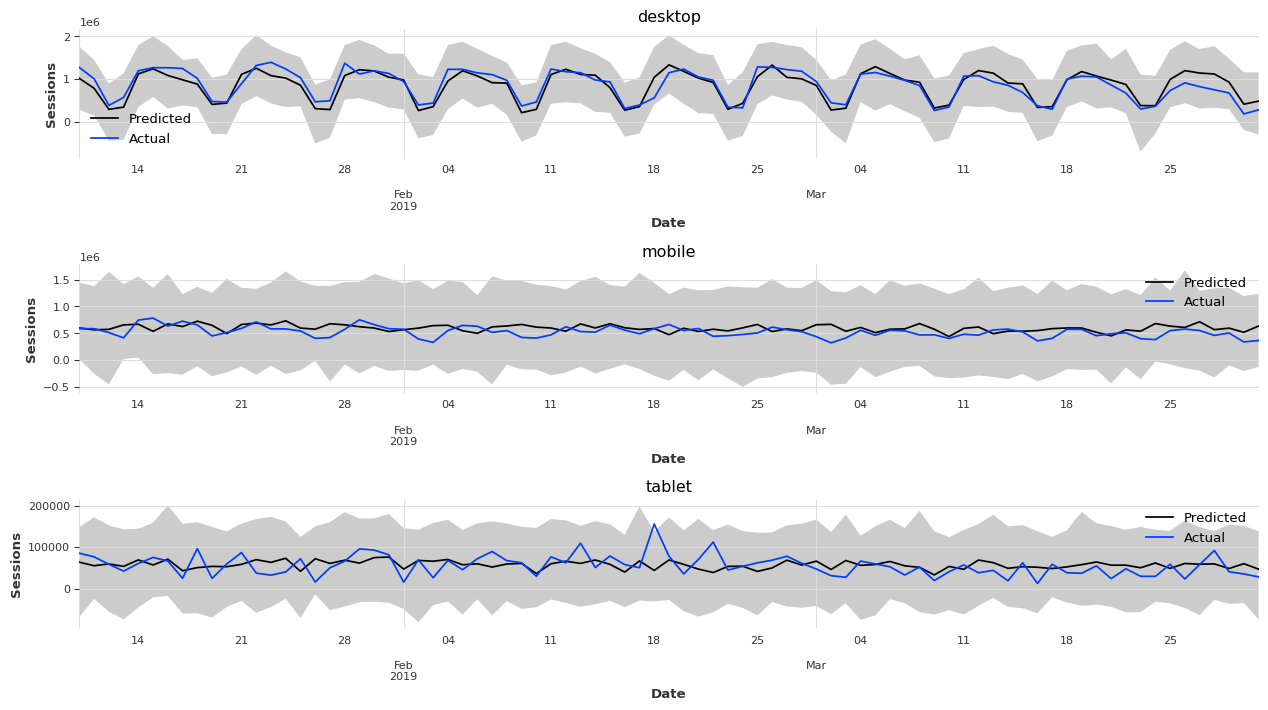

In [9]:
fig,ax = plt.subplots(3,1,figsize=(1280/96, 720/96), dpi=96)
preds_ = preds[preds['Date'] >= '2019-01-10']
for ax_, device in enumerate(preds_['Device Category'].unique()):
    p_ = preds_.loc[preds_['Device Category'] == device]
    p_.rename(columns={'Sessions': 'Actual', 'Sessions_0.5': 'Predicted'}, inplace=True)
    ax[ax_].fill_between(p_['Date'], p_['Sessions_0.05'], p_['Sessions_0.95'], alpha=0.2)
    p_.plot(x='Date', y=['Predicted', 'Actual'], ax=ax[ax_], title=device)
    ax[ax_].set_xlabel('Date')
    ax[ax_].set_ylabel('Sessions')
fig.tight_layout()

In [ ]:
from sklearn.metrics import mean_pinball_loss
for q in [0.05, 0.5, 0.95]:
    print(f'Pinball loss at {q}: {mean_pinball_loss(preds["Sessions"], preds[f"Sessions_{q}"])}')

## Resources

* https://forecastegy.com/posts/kalman-filter-for-time-series-forecasting-in-python/#training-the-kalman-filter-for-time-series-forecasting
* https://www.youtube.com/watch?v=CaCcOwJPytQ&list=PLk4mwFjvagV3NdW8nsVS7Sr1WJjCw2npD&index=1
* NSID: Subspace Algorithms for the Identication of Combined Deterministic Stochastic Systems: https://people.duke.edu/~hpgavin/SystemID/References/VanOverschee-Automatica-1994.pdf